In [20]:
import math
import matplotlib.pyplot as plt

# Исходные данные
# Параметры задачи (вариант 5)
h0 = 4.4 # Высота жидкости в компенсационной емкости
h1 = 0.2 # Постоянная высота жидкости в рабочей емкости
S = 0.4 # Площадь сечения рабочей емкости (зеркала жидкости)
G = 3400 # Массовый расход ткани, г/с
m1 = 0.12 # Уровень влажности ткани до окраски
m2 = 1.0 # Уровень влажности ткани после окраски
ρ = 500 # Плотность ткани, кг/м3
tп = 15 # Время переходного процесса, с

h1h01h01 = (3, 5) # 3..5 Точность измерения уровня жидкости в рабочей емкости

σ = 25 # Перерегулирование, %
ξ = (70, 75) # 70..75 Затухание за период, %
g = 9.8 # Ускорение свободного падения, м/с2

φ_max = 14 # Угол вращения вала исполнительного двигателя, соответствующий перемещению клапана f1 от 0..fmax
f_max = 3 # Максимальное проходное сечения проходного клапана f1

ε = 0.6 # Коэффициент расхода жидкости через клапан
t_п = 15 # Время переходного процесса объекта управления, с
m = 3 # 3..4 # Масса сильфона, кг (?)
k_дин = 1.5 # 1.5..2.5 
M_ст = 1.5 # 1.5..3.0


print(f'{k_дин=:.3f}')

k_дин=1.500


In [32]:
# Стр. 31
# Проходное сечение клапана в номинальном режиме
# f1 = ((G * math.pow(10, -3) * (m1 - m2))) / (ε * math.sqrt(2 * g) * (h0 - h1)) # * 10^-3 м2/с
f1 = (1 / (ρ*ε)) * (abs(G - (m2 - m1)) 
                    / 
                    (math.sqrt(2 * g) * (h0 - h1))) # * math.pow(10, -2) m2
# f1 = f1 * pow(10, -2)

# Постоянная времени объекта управления, с
T_о = ((2*S) * math.sqrt(h0 - h1)) / (f1 * ε * math.sqrt(2 * g))  # +
# Коэффициент передачи объекта управления
k_о = (2 * (h0 - h1)) / f1 # * 10^-3
# Максимальная величина проходного сечения рег. клапана
f1_max = 4 * f1
# Коэффициент передачи регулирующего графика
k_ро = f1_max / φ_max # м3/с
f1 = round(f1, 3)
f1_max = round(f1_max)
T_о = round(T_о, 3)
k_о = round(k_о, 3)
k_ро = round(k_ро, 3)
print(f'{f1=}*10^-2 {T_о=} {k_о=} {f1_max=} {k_ро=}')


f1=0.609*10^-2 T_о=1.013 k_о=13.785 f1_max=2 k_ро=0.174


In [36]:
# Стр. 32
## Рассчитываем мощность двигателя
# Скорость вращения регулирующего органа
n_ро = ((0.2 * φ_max) / t_п) * 60 # об/мин
# Мощность двигателя
k_дин = 1.5
P = (k_дин * (M_ст) * (n_ро)) / 0.975 # ~ 27.7 Вт

n_ро = round(n_ро, 3)
P = round(P, 1)

print(f'{n_ро=} {P=}')

n_ро=11.2 P=25.8


In [22]:
## Выбираем двигатель СЛ-367
U = 110
P = 32
n_дв = 2500
I = 0.07
# Параметры обмотки якоря
R_я = 1.5
I_я = 0.9

print(f'{n_дв=:.3f}')

n_дв=2500.000


In [37]:
# Стр. 33
# Постоянная двигателя
C_дв = (U - I*R_я) / (n_дв * (2*math.pi/60))
# Постоянная времени двигателя
T_м = round((I * R_я) / (C_дв * C_дв), 2)
# Коэффициент двигателя
k_дв = round(1 / C_дв)
Wдв_p = k_дв / (T_м * ρ + 1) * ρ
# Коэффициент редуктора
k_р = n_ро / n_дв
C = 1000 # Н/м # Уточнить значение
k_d = (ρ * g * S * pow(10, -2)) / C
# Постоянная вращения
T_k = math.sqrt(m / (2 * C))
T_d = 2 * S * T_k
# Постоянная измеритеря уровня
W_и_p = k_р / ((T_k*T_k)*(ρ*ρ)+T_d*ρ+1)
# Сравнивающее устровйство
k_тс = 10
W_эм_p = k_тс
# Постоянная электронного усилителя
# W_у_p = k_у
# Магнитное усиление
k_му = 100; T_му = 1
W_му_p = k_му / (T_му * ρ + 1)
# Регулирующий орган
q_потр = f_max * ε * math.sqrt((2 * g) * (h0 - h1)) # м3/с, объемный секундный расход жидкости из емкости
# Корректирующий элемент
# W_дос_p = 1 / (T_ос * ρ + 1)
# W_ек_p = (k_му * (T_ос * ρ + 1)) / ((T_му * ρ + 1)*(T_ос * ρ + 1)+k_му)

## Расчет передаточной функции системы
# Коэффциент передачи разомкнутой системы
# k_рс = k_тс * k_му * k_дв * k_р * k_ро * k_d * k_о # * k_у

# W_рс_p = k_pc * k_у * (T_ос * ρ + 1) / 
#           [(T_му * ρ + 1) * (T_ос * ρ + 1) + k_му] * (T_k^2 * ρ^2 + T_d * ρ + 1) * (T_м * ρ + 1) * (T_оу * ρ + 1)
# W_p = h1/hзад = W_рс_p / 1 + W_рс_p

print(f'{T_м=:.3f} {k_р=:.3f} {k_d=:.3f} {T_k=:.3f} {T_d=:.3f} {k_тс=:.3f} {k_му=:.3f} {k_му=:.3f}')

# Уравнение системы (стр. 30)

Подставляем полученные переменные

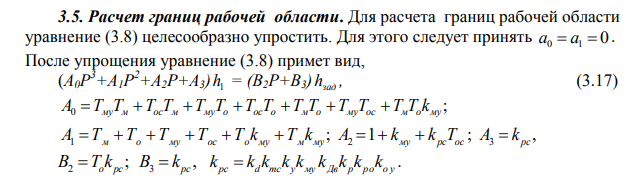

In [29]:

# assert μ <= 4.89 # Алгоритмы МЭПН можно применять лишь в том случае, если выполнена исходная предпосылка - требование по колебательности системы
# Далее используем имплементируем алгоритм на стр. 39 методических указаний

A_0 = f'{str(T_му*T_м)}+T_ос*{str(T_м*T_му*T_о)}+T_ос*{str(T_о)}+{str(T_м*T_о)}+{str(T_му)}*T_ос+{str(T_м*T_о)}*k_му'
# A_1 = T_м + T_о + T_му + T_ос + T_о*k_му + T_м*k_му
# A_2 = 1 + k_му + k_рс*T_ос
# A_3 = k_рс
# B_2 = T_о*k_рс
# B_3 = k_рс

print(A_0)

0.5958962956308599+T_ос*0.6035845515869505+T_ос*1.0129020032721485+0.6035845515869505+1*T_ос+0.6035845515869505*k_му


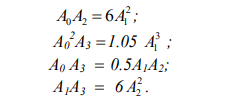
Приводим уравнения к функциям для рассчёта коэффициентов
стр. 30